In [1]:
from fastai import *
from fastai.vision import *
from pathlib import Path

from fastai_autoencoder.bottleneck import VAEBottleneck
from fastai_autoencoder.decoder import SpatialDecoder2D
from fastai_autoencoder.learn import AutoEncoderLearner
from fastai_autoencoder.callback import VAEHook
from fastai_autoencoder.util import *

In [2]:
def create_encoder(nfs,ks,strides,conv=nn.Conv2d,bn=nn.BatchNorm2d,act_fn = nn.ReLU):
    n = len(nfs)
    
    conv_layers = [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i],
                              stride=strides[i],conv = conv,bn=bn,act_fn=act_fn,padding = ks[i] //2)
                                   for i in range(n-1)]        
    convs = nn.Sequential(*conv_layers)
    
    return convs

def create_decoder(nfs,ks,conv = nn.Conv2d,bn = nn.BatchNorm2d,act_fn = nn.ReLU):
    n = len(nfs)
    
    # We add two channels to the first layer to include x and y channels
    first_layer = ConvBnRelu(nfs[0] + 2, nfs[1],conv = PointwiseConv,bn=bn,act_fn=act_fn)

    conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                              padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                   for i in range(1,n - 1)]        
    dec_convs = nn.Sequential(*conv_layers)
    
    return dec_convs

def get_data(train_size,bs = 64,size = 64,gray = True):

    path = untar_data(URLs.MNIST)
    tfms = get_transforms(do_flip = False)

    data = (ImageList.from_folder(path/"training")
            .split_none()
            .label_from_folder()
            .transform(tfms,size = size)
            .databunch(bs = bs))

    # Creation of a small dataset of all images
    n = len(data.train_ds.x.items)

    train_idx = np.random.choice(n,train_size,replace = False)
    x_train,y_train = data.train_ds.x.items[train_idx],data.train_ds.y.items[train_idx]
    train_df = pd.DataFrame({"name":x_train,"label":y_train})
    
    valid_idx = np.array(list(set(np.arange(n)) - set(train_idx)))
    x_valid,y_valid = data.train_ds.x.items[valid_idx],data.train_ds.y.items[valid_idx]
    valid_df = pd.DataFrame({"name" : x_valid,"label":y_valid})

    path = Path("/")

    # Data used ofr the training of the autoencoder
    data = (ImageList.from_df(train_df,path)
            .split_by_rand_pct(seed=42)
            .label_from_df()
            .transform(tfms,size = size)
            .databunch(bs = bs))
    
    valid_data = (ImageList.from_df(valid_df,path)
            .split_none()
            .label_from_df()
            .transform(tfms,size = size)
            .databunch(bs = bs))
    
    def get_one_channel(batch):
        x,y = batch
        return x[:,0,:,:].unsqueeze(1),y
    get_one_channel._order = 99
    
    if gray:
        data.add_tfm(get_one_channel)
        valid_data.add_tfm(get_one_channel)
    
    return data, valid_data

In [6]:
train_size = 2048
train_size = int(train_size * 1.25)

data, valid_data = get_data(train_size,bs=64)

In [7]:
im_size = 64
conv = nn.Conv2d
act_fn = nn.ReLU
bn = nn.BatchNorm2d

nfs = [1,8,16,32,64]
ks = [7,3,3,3]
strides = [2,2,2,2]
enc = create_encoder(nfs,ks,strides,conv=conv,bn=bn,act_fn=act_fn)

nfs = [1024,24]
vae_bn = VAEBottleneck(nfs,act_fn)

nfs = [24,32,32,16,8,1]
ks = [7,3,3,3]
dec_conv = create_decoder(nfs,ks,conv=conv,bn=bn,act_fn=act_fn)
dec = SpatialDecoder2D(dec_conv,im_size)

learn = AutoEncoderLearner(data,F.mse_loss,enc,vae_bn,dec)
kl_hook = VAEHook(learn,beta=1)

In [8]:
learn.fit_one_cycle(15,1e-2)

epoch,train_loss,valid_loss,time
0,390.144592,382.069275,00:12
1,356.531891,418.575409,00:03
2,335.896393,376.618103,00:04
3,281.735748,383.211853,00:03
4,230.695663,324.213318,00:04
5,193.766312,339.712158,00:04
6,165.677551,350.340485,00:04
7,146.270172,264.049713,00:04
8,129.991013,368.171631,00:04
9,118.556877,171.581879,00:04


In [9]:
learn.fit_one_cycle(15,1e-2,callbacks = [kl_hook])

epoch,train_loss,valid_loss,time
0,80.537674,88.618698,00:04
1,84.268257,227.604187,00:04
2,91.629120,523.642822,00:04
3,97.434486,372.246399,00:04
4,96.379921,671.706360,00:04
5,96.247009,408.388550,00:03
6,92.161911,413.392731,00:04
7,90.358803,266.039734,00:04
8,86.631378,322.776672,00:04
9,82.784691,248.507614,00:04


In [10]:
learn.fit_one_cycle(10,1e-3,callbacks = [kl_hook])

epoch,train_loss,valid_loss,time
0,63.070335,49.863136,00:04
1,63.397228,90.194252,00:04
2,65.432533,136.647324,00:04
3,65.504837,106.263695,00:04
4,65.224464,155.940796,00:04
5,64.642838,72.478600,00:04
6,63.081005,63.932487,00:04
7,63.066628,55.870827,00:04
8,61.946602,46.468700,00:04
9,61.518291,45.748409,00:04


In [13]:
learn.fit_one_cycle(15,1e-3,callbacks = [kl_hook])

epoch,train_loss,valid_loss,time
0,61.069954,46.668884,00:04
1,61.905186,75.614799,00:04
2,61.452690,78.122971,00:04
3,63.029964,124.267441,00:04
4,63.708660,181.199890,00:04
5,63.554100,120.349358,00:04
6,63.391598,121.243423,00:04
7,63.322983,110.887627,00:04
8,62.845562,75.088120,00:04
9,62.532200,74.419205,00:04


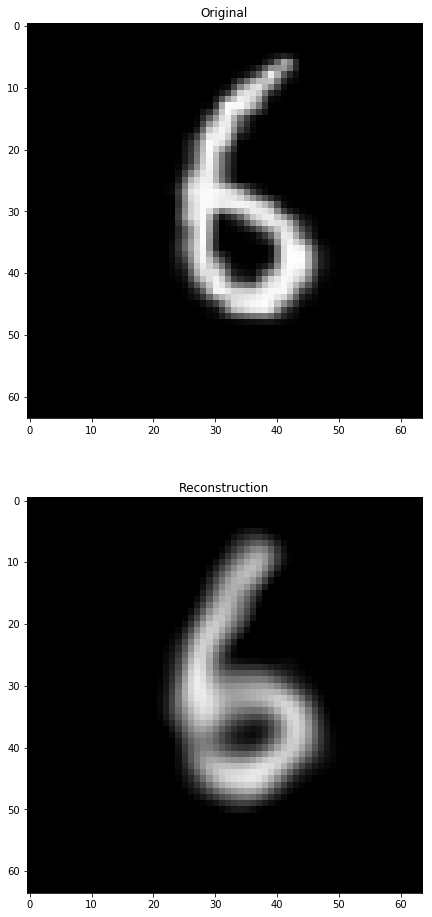

In [22]:
learn.plot_rec()

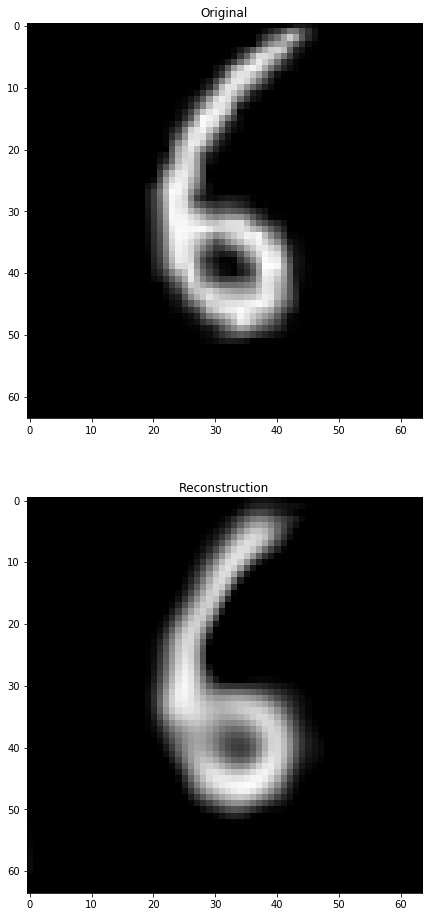

In [131]:
learn.plot_rec()

In [34]:
learn.path = Path()
learn.load("model_2048_sample_cnn")

AutoEncoderLearner(data=ImageDataBunch;

Train: LabelList (2048 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
7,0,7,3,3
Path: /;

Valid: LabelList (512 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
7,5,1,8,3
Path: /;

Test: None, model=Sequential(
  (0): Sequential(
    (0): ConvBnRelu(
      (conv): Conv2d(1, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU(inplace)
    )
    (1): ConvBnRelu(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU(inplace)
    )
    (2): ConvBnRelu(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchN

In [19]:
def plot_shades(learn,x=None,i=0,n_perturb = 13, mag_perturb = 3, ax = None,gray = True):
    """Plot the reconstruction of the """
    learn.model.cpu()
    if not isinstance(x,torch.Tensor):
        x,y = learn.data.one_batch()

    x = x[i].unsqueeze(0)

    # We get the latent code
    z = learn.encode(x)
    n_z = z.shape[1]

    # We create a scale of perturbations
    mag_perturb = np.abs(mag_perturb)
    scale_perturb = np.linspace(-mag_perturb,mag_perturb,n_perturb)

    if not ax:
        fig, ax = plt.subplots(n_z,n_perturb, figsize=(20,20))
        fig.tight_layout()

    for i in range(n_z):
        for (j,perturb) in enumerate(scale_perturb):
            # For each z_i we add a minor perturbation
            z_perturb = z.clone()
            z_perturb[0,i] += perturb

            # We reconstruct our image
            x_rec = learn.decode(z_perturb)
            
            # We plot it in the grid
            img = x_rec.squeeze(0).permute(1,2,0).detach().numpy()
            if gray:
                img = np.concatenate([img,img,img],axis = -1)
            ax[i][j].set_axis_off()
            ax[i][j].imshow(img)
            ax[i][j].set_title(f"z_{i} with {round(perturb * 1e2) / 1e2}")

In [35]:
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from fastai.core import parallel

params = {"criterion" : "entropy",
     "max_depth" : 10,
     "max_features" : 0.8,
     "n_jobs" : -1}

def create_random_forest(learn,n_rf,bs = 512,n_batch = 1,**kwargs):
    rfs = []
    learn.data.batch_size = bs
    for i in range(n_rf):
        z,y = learn.get_latents(DatasetType.Train,n_batch=n_batch)
        z,y = z.numpy(),y.numpy()
        
        rf = RandomForestClassifier(**kwargs)
        rf.fit(z,y)
        rfs.append(rf)
        
    return rfs

def vote(a,threshold = 0.5):
    values,count = np.unique(a,return_counts=True)
    total = np.sum(count)
    max_count = np.argmax(count)
    
    if count[max_count] / total < threshold:
        return -1
    else:
        output = values[max_count]
        return output
    
        
def compute_score(y_pred,y_valid):
    """Compute the number of times the trees agree and what is their accuracy on the agreed votes"""
    idx = (y_pred != -1)
    vote_pct = np.sum(idx) / len(idx)
    score = (y_pred[idx] == y_valid[idx]).mean()
    return vote_pct,score

In [36]:
rfs = create_random_forest(learn,n_rf=1,n_estimators = 10,bs = 512,n_batch = 2,**params)

In [37]:
rf = rfs[0]

In [108]:
x,y = learn.data.one_batch(DatasetType.Valid)
learn.model.cpu()
with torch.no_grad():
    z = learn.encode(x)

In [54]:
df = dict(zip( np.arange(len(rf.feature_importances_)),rf.feature_importances_))

In [ ]:
z.cl

In [83]:
z[0].shape

torch.Size([24])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

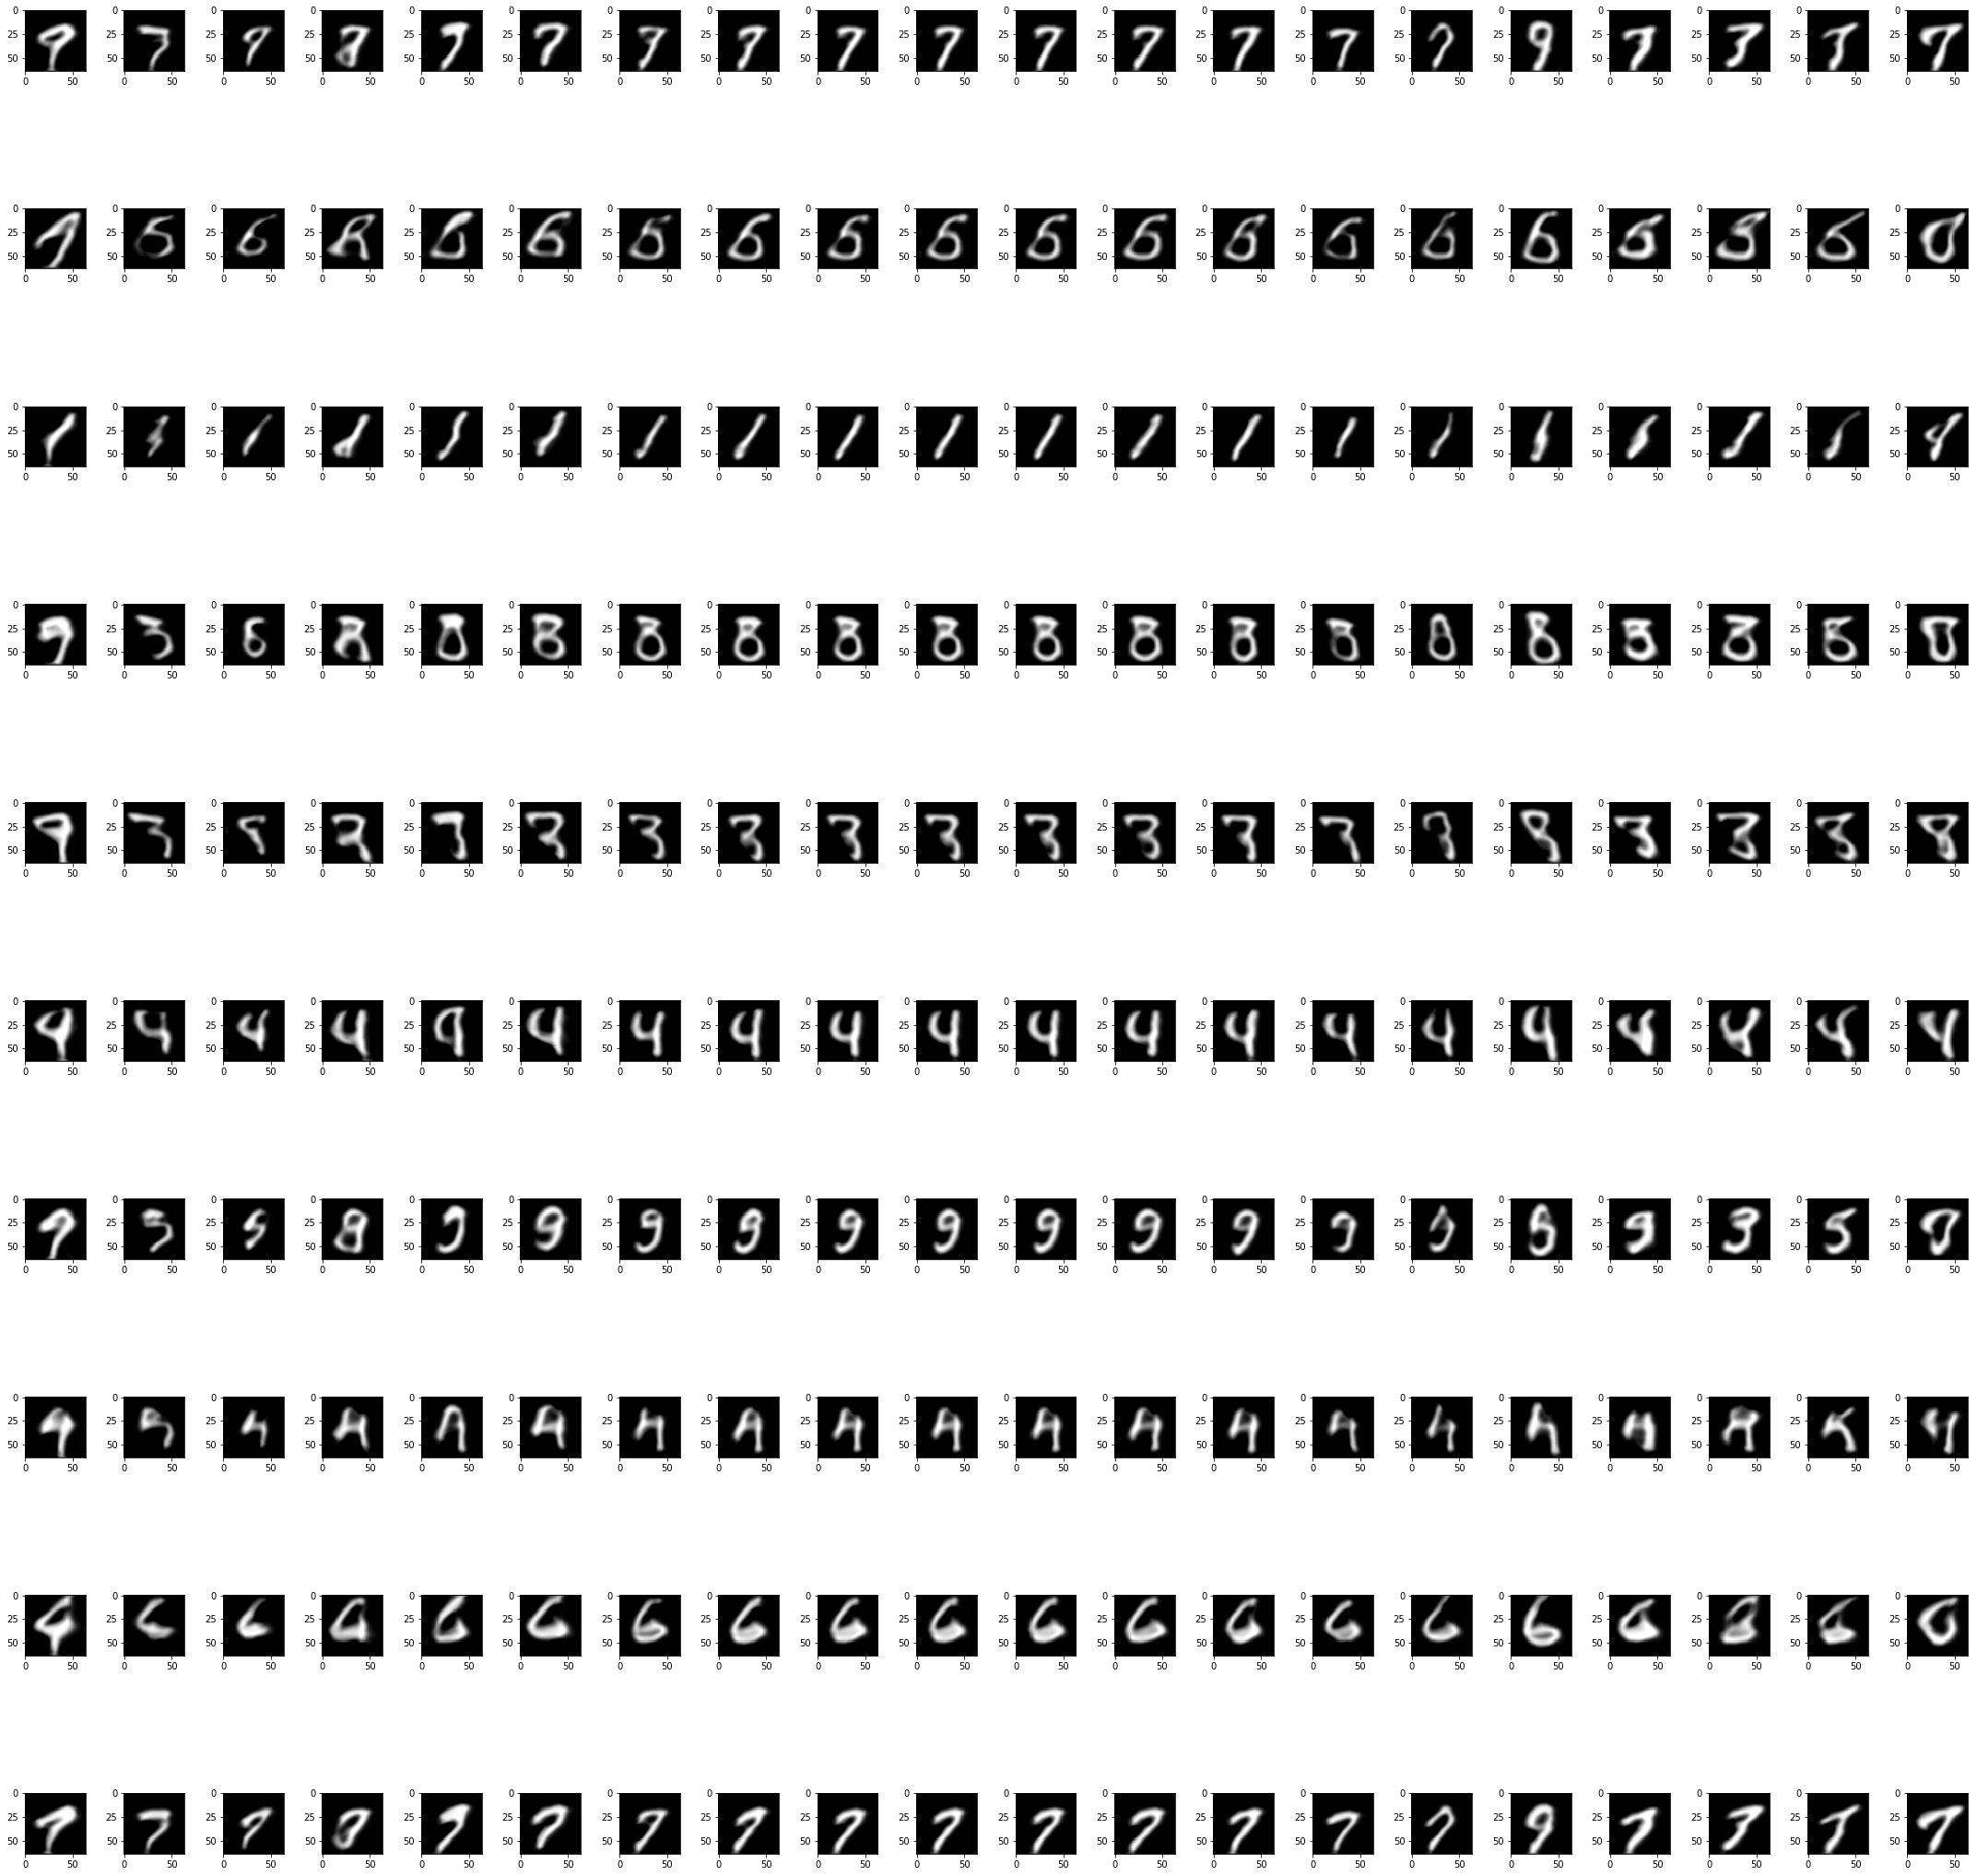

In [109]:
import warnings
warnings.filterwarnings("ignore")

j = 12
bs = 10
z = z[:bs]

mag_perturb = 1
n_perturb = 20

mag_perturb = np.abs(mag_perturb)
scale_perturb = np.linspace(-mag_perturb,mag_perturb,n_perturb)
ax = None
if not ax:
    fig, ax = plt.subplots(bs,n_perturb, figsize=(30,30))
    fig.tight_layout()
for row in range(bs):
    for (col,eps) in enumerate(scale_perturb):
        z_perturb = z.clone()
        z_perturb = z_perturb[row]
        z_perturb[col] += eps
        x_rec = learn.decode(z_perturb.unsqueeze(0))
        
        x_rec = x_rec.detach()[0].permute(1,2,0).numpy()
        img = np.concatenate([x_rec,x_rec,x_rec],axis = -1)
        ax[row][col].imshow(img)

In [63]:
sorted(df.items(),key = lambda x : x[1],reverse = True)

[(12, 0.15131273714585355),
 (11, 0.09151100660864651),
 (10, 0.08931936001213468),
 (14, 0.0644866349863583),
 (2, 0.05973366867132986),
 (3, 0.051156075291391566),
 (0, 0.0486653631437793),
 (21, 0.04788081256871918),
 (20, 0.04497470289771256),
 (18, 0.04239235347757288),
 (13, 0.04235528160979805),
 (6, 0.041999027578566626),
 (4, 0.04018967725491911),
 (9, 0.028892950798016726),
 (19, 0.023005326461794526),
 (23, 0.019437998351800795),
 (15, 0.01925211437554033),
 (1, 0.016776599790886186),
 (17, 0.015940078351748092),
 (7, 0.01362969626916929),
 (5, 0.013451485369654717),
 (16, 0.01342869080522895),
 (22, 0.01033910414382436),
 (8, 0.009869254035553868)]

In [45]:
rf.decision_path(z)

(<512x2700 sparse matrix of type '<class 'numpy.int64'>'
 	with 42448 stored elements in Compressed Sparse Row format>,
 array([   0,  257,  510,  791, 1058, 1327, 1602, 1875, 2156, 2427, 2700]))

In [85]:
def compute_metrics(learn,z_valid,y_valid,n_batch,n_estimators,n_rf,bs = 512):
    # First we add the data set with the right size to our learner
    params["n_estimators"] = n_estimators
    
    rfs = create_random_forest(learn,n_rf,n_batch=n_batch,bs=bs,**params)
    
    y = []
    for rf in rfs:    
        for tree in rf.estimators_:
            y.append(tree.predict(z_valid).reshape(-1,1))

    y = np.concatenate(y,axis = -1).astype(int)
    
    y_pred = np.apply_along_axis(vote,1,y)
    
    output = {"train_size":n_batch*bs,"n_estimators":n_estimators,"n_rf":n_rf}
    output["vote_pct"], output["score"] = compute_score(y_pred,y_valid)
    
    return output

In [66]:
z_valid,y_valid = learn.get_latents(DatasetType.Train)

In [72]:
z_valid,y_valid = z_valid.numpy(),y_valid.numpy()

In [91]:
learn.data = data

In [95]:
# train_size = [1024,2048,4096]
n_batch = [1,2,4]
# n_rf = [1,1,10,20,1]
n_rf = [1,10,20]
# n_estimators = [10,100,10,10,200]
n_estimators = [10,10,10]

outputs = []

for n in n_batch:
    for n_r,n_e in zip(n_rf,n_estimators):
        print(f"Computing {t} with {n_r} forests and {n_e} trees")
        output = compute_metrics(learn,z_valid,y_valid,n_batch=n,n_estimators=n_e,n_rf=n_r)
        outputs.append(output)

In [96]:
results = pd.DataFrame(outputs)
results

,n_estimators,n_rf,score,train_size,vote_pct
0,10,1,0.830848,512,0.719186
1,10,10,0.950849,512,0.591797
2,10,20,0.951197,512,0.589233
3,10,1,0.848228,1024,0.787179
4,10,10,0.945918,1024,0.673915
5,10,20,0.948443,1024,0.672764
6,10,1,0.867999,2048,0.828857
7,10,10,0.943155,2048,0.744542
8,10,20,0.947688,2048,0.737061


In [21]:

results = pd.DataFrame(outputs)
results.to_csv("results.csv",index = None)

In [22]:
results["mean"] = (results["vote_pct"] + results["score"]) * 0.5

In [23]:
results

,n_estimators,n_rf,score,train_size,vote_pct,mean
0,10,1,0.837011,1024,0.721882,0.779446
1,100,1,0.934247,1024,0.599205,0.766726
2,10,10,0.940864,1024,0.596208,0.768536
3,10,20,0.949533,1024,0.591527,0.770530
4,200,1,0.943389,1024,0.583833,0.763611
5,10,1,0.859114,2048,0.773589,0.816352
6,100,1,0.928775,2048,0.671841,0.800308
7,10,10,0.943587,2048,0.658119,0.800853
8,10,20,0.949902,2048,0.653354,0.801628
9,200,1,0.936789,2048,0.669383,0.803086


In [68]:


params = {"n_estimators":200,
         "criterion" : "entropy",
         "max_depth" : 10,
         "max_features" : 0.8,
         "n_jobs" : -1}

n_rf = 1

rfs = create_random_forest(learn,n_rf,**params)




    
y_pred = np.apply_along_axis(vote,1,y)

In [69]:
# Single rf : 3000 samples
idx = (y_pred != -1)
print(np.sum(idx) / len(idx))
(y_pred[idx] == y_valid[idx]).mean()

0.8170460668103449


0.8694926431191526

In [67]:
# Multiple rf : 3000 samples
idx = (y_pred != -1)
print(np.sum(idx) / len(idx))
(y_pred[idx] == y_valid[idx]).mean()

0.7785391971982759


0.931832435822574

In [56]:
uncert = (y_pred == -1 )

In [75]:
v,c = np.unique(learn.data.valid_ds.y[uncert].items,return_counts=True)

In [79]:
df = pd.DataFrame({"index" : v,"count" : c})


,index,count
0,0,423
1,1,138
2,2,790
3,3,768
4,4,586
5,5,685
6,6,362
7,7,701
8,8,1513
9,9,595


In [80]:
df.sort_values("count")

,index,count
1,1,138
6,6,362
0,0,423
4,4,586
9,9,595
5,5,685
7,7,701
3,3,768
2,2,790
8,8,1513


In [46]:
# Multiple rf
idx = (y_pred != -1)
print(np.sum(idx) / len(idx))
(y_pred[idx] == y_valid[idx]).mean()

0.8633125


0.9392118535678949

In [54]:
rf = rfs[0]

In [55]:
labels = [f"z_{i}" for i in range(len(rf.feature_importances_))]
feats = rf.feature_importances_
df = pd.DataFrame(labels,feats)

In [56]:
df.sort_index()

,0
0.006576,z_12
0.006695,z_7
0.008128,z_24
0.008643,z_29
0.010957,z_17
0.011098,z_16
0.011183,z_28
0.013577,z_14
0.014662,z_18
0.016579,z_10


In [16]:
X_test = z_valid

sample_id = 0
estimator = rfs[0].estimators_[0]

In [22]:
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right

In [21]:
node_indicator = estimator.decision_path(X_test)
leave_id = estimator.apply(X_test)

feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

Rules used to predict sample 0: 
decision id node 0 : (X_test[0, 7] (= -4.7002635) <= -3.9674233198165894)
decision id node 1 : (X_test[0, 10] (= -4.1538806) <= -3.8830102682113647)
decision id node 2 : (X_test[0, 4] (= 1.769853) <= 1.8463399410247803)
decision id node 3 : (X_test[0, 2] (= -4.7491693) <= -4.232415437698364)
decision id node 4 : (X_test[0, 1] (= 1.9424701) > 1.924157440662384)
decision id node 56 : (X_test[0, 14] (= 1.2844998) <= 1.400970697402954)
decision id node 57 : (X_test[0, 13] (= -0.15352787) > -0.5334719717502594)
decision id node 69 : (X_test[0, 4] (= 1.769853) > 1.5273671746253967)
decision id node 77 : (X_test[0, 2] (= -4.7491693) <= -4.639214754104614)
decision id node 78 : (X_test[0, 10] (= -4.1538806) > -4.450443983078003)


In [112]:
21 % 5

1

In [119]:
def plot_node_reconstruction(learn, tree, z_valid,y_valid,node_id = 0,n_imgs = 20):

    idx = (tree.decision_path(z_valid)[:,node_id].toarray() == 1.).reshape(-1)
    
    # We take the mean of the images in the given node
    z = z_valid[idx,:]
    y = y_valid[idx]
    
    values,count = np.unique(y,return_counts=True)
    print(f"Values : {values} with distribution {count}")
    
#     value, count = np.unique(y,return_counts=True)
#     max_count = np.argmax(count)
#     max_label = value[max_count]
    
#     idx = (y == max_label)
    
#     z = z[idx,:]
    
    if not isinstance(z,torch.Tensor):
        z = torch.tensor(z)
    learn.model.cpu()
    with torch.no_grad():
        imgs = learn.decode(z)
    
    n = z.shape[0]
    n_sample = min(n,n_imgs)
    
    idx = np.random.choice(n,n_sample,replace = False)
    
    z = z[idx,:]
    y = y[idx]
    
    img_per_row = 5
    n_rows = n_sample // img_per_row
    if n_sample  % img_per_row != 0:
        n_rows += 1
        
    f, ax = plt.subplots(n_rows,img_per_row,figsize = (20,20))
    
    for i in range(n_rows):
        for j in range(img_per_row):
            img = imgs[i * img_per_row + j].permute(1,2,0).numpy()
            img = np.concatenate([img,img,img],axis = -1)
            ax[i,j].imshow(img)
            ax[i,j].set_title(f"Label : {y[i]}")

Values : [4 7 8 9] with distribution [ 59 599   5 407]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

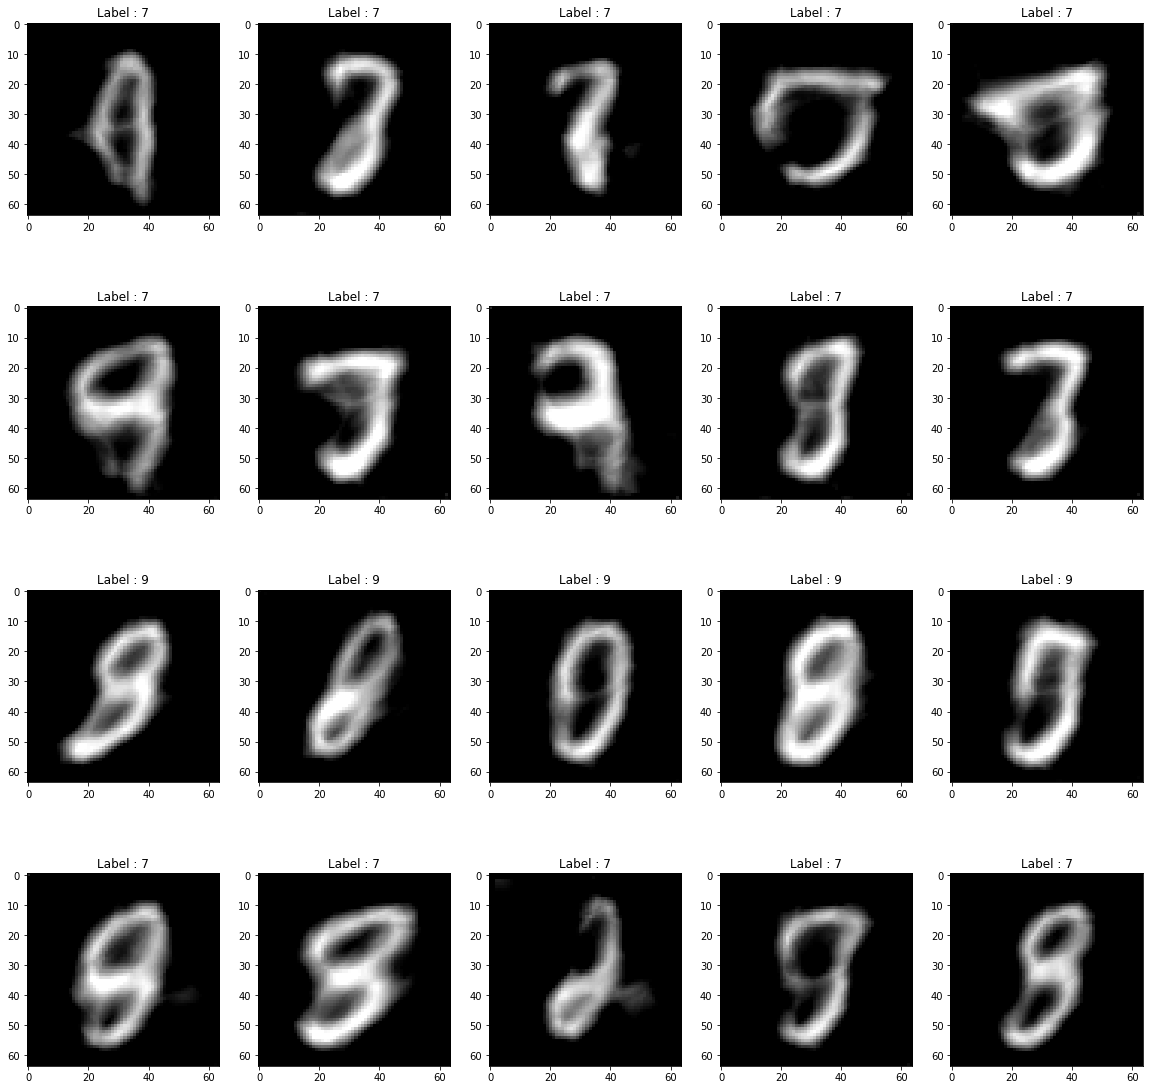

In [122]:
plot_node_reconstruction(learn,estimator,z_valid,y_valid,77)

Freezing all layers
Unfreezing all layers


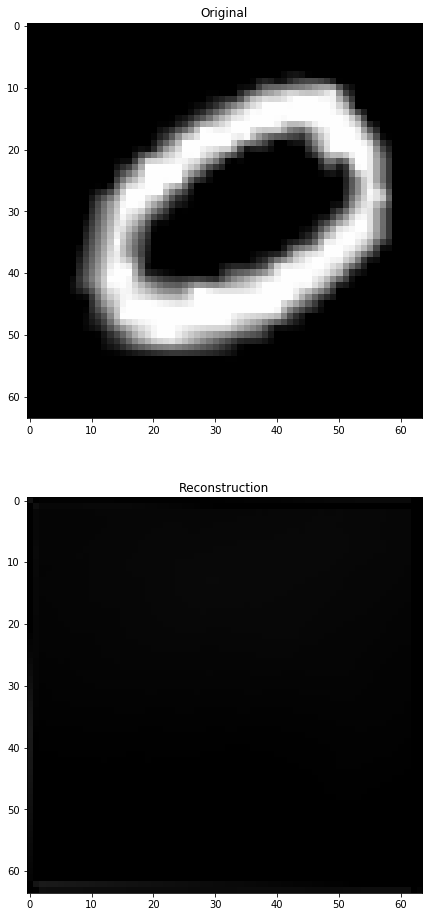

In [28]:
from fastai_autoencoder.util import lsuv_init

def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Linear)
    return isinstance(l, lin_layers)

layers = find_modules(learn.model, is_lin_layer)
output = lsuv_init(learn.model,x.cuda(),layers=layers)
learn.plot_rec(x)

In [55]:
# We load the former model
learn.path = Path()
learn = learn.load(Path("model"))

In [29]:
learn.fit(1,1e-4)

epoch,train_loss,valid_loss,time
0,383.507355,360.482971,00:51


In [30]:
# Batchnorm without LSUV
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

epoch,train_loss,valid_loss,time
0,152.533173,135.702316,00:52
1,109.294441,93.152649,00:51


epoch,train_loss,valid_loss,time
0,94.334465,166.097168,00:52
1,81.429611,66.828392,00:51


epoch,train_loss,valid_loss,time
0,80.085953,144.533447,00:52
1,72.479675,57.421322,00:51


epoch,train_loss,valid_loss,time
0,72.561394,107.953918,00:52
1,66.752518,52.354488,00:52


In [31]:
# We load the former model
learn.path = Path()
learn.save("model")

In [32]:
# Batchnorm without LSUV
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

epoch,train_loss,valid_loss,time
0,67.297760,92.637917,00:53
1,62.453762,48.557568,00:52


epoch,train_loss,valid_loss,time
0,65.587029,113.099106,00:51
1,59.489765,46.318256,00:52


epoch,train_loss,valid_loss,time
0,62.109524,100.897247,00:52
1,58.130547,44.578648,00:52


epoch,train_loss,valid_loss,time
0,60.766949,144.446915,00:52
1,56.150398,43.010925,00:52


In [48]:
# We load the former model
learn.path = Path()
learn.save("model")

In [52]:
learn.load("model")

AutoEncoderLearner(data=ImageDataBunch;

Train: LabelList (48000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
5,5,5,5,5
Path: /home/DanyWin/.fastai/data/mnist_png/training;

Valid: LabelList (12000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
7,1,1,2,2
Path: /home/DanyWin/.fastai/data/mnist_png/training;

Test: None, model=Sequential(
  (0): Encoder(
    (enc_convs): Sequential(
      (0): MobileConv(
        (depth_conv): DepthwiseConv(
          (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): ReLU(inplace)
        )
        (point_conv): PointwiseConv(
          (conv): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(8, eps=1e-05, moment

Computing the TSNE projection


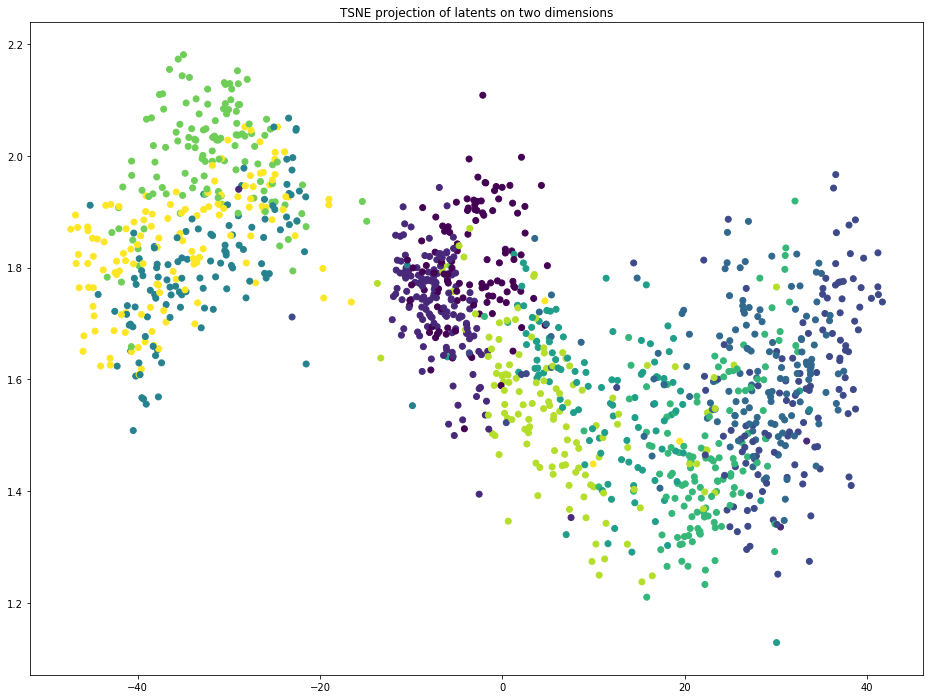

In [53]:
learn.plot_2d_latents()

In [49]:
# Batchnorm without LSUV
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

epoch,train_loss,valid_loss,time
0,57.213802,74.782753,00:52
1,52.283051,40.029442,00:52


epoch,train_loss,valid_loss,time
0,55.669727,110.084648,00:52
1,51.821789,39.593864,00:52


Computing the TSNE projection


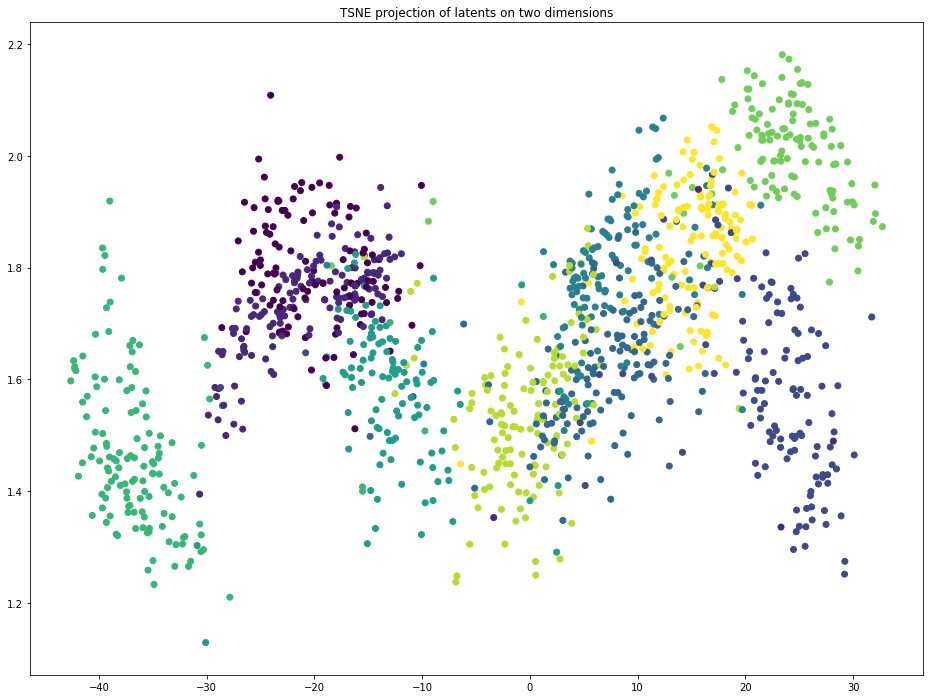

In [50]:
learn.plot_2d_latents()

In [51]:
learn.path = Path()
learn.save("model")

In [56]:
# Batchnorm + LSUV Linear
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

epoch,train_loss,valid_loss,time
0,359.752563,341.500824,00:52
1,355.527985,339.326813,00:52


epoch,train_loss,valid_loss,time
0,313.254883,379.046082,00:52
1,209.952744,192.542297,00:53


epoch,train_loss,valid_loss,time
0,144.043869,139.578751,00:52
1,105.654976,88.906311,00:53


epoch,train_loss,valid_loss,time
0,91.867798,88.411674,00:53
1,78.289078,62.504765,00:53


epoch,train_loss,valid_loss,time
0,74.689232,89.515717,00:53
1,67.384964,51.905613,00:53


In [9]:
# LSUV without BN
learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

learn.fit_one_cycle(2,1e-3,callbacks=[kl_hook])

epoch,train_loss,valid_loss,time
0,505.914124,424.364380,00:45
1,431.141815,406.954834,00:46


epoch,train_loss,valid_loss,time
0,398.508270,345.695007,00:46
1,94684.343750,344.612701,00:46


epoch,train_loss,valid_loss,time
0,316.774323,286.658508,00:46


Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/anaconda/envs/naox3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/data/anaconda/envs/naox3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/data/anaconda/envs/naox3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/data/anaconda/envs/naox3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/data/anaconda/envs/naox3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/data/anaconda/envs/naox3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/data/anaconda/envs/naox3/lib/python3.7/multiprocessing/connection.py", line 404, in _

KeyboardInterrupt: 

In [7]:
learn.path = Path(".")
learn.load("model")

AutoEncoderLearner(data=ImageDataBunch;

Train: LabelList (48000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
5,5,5,5,5
Path: /home/DanyWin/.fastai/data/mnist_png/training;

Valid: LabelList (12000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
7,1,1,2,2
Path: /home/DanyWin/.fastai/data/mnist_png/training;

Test: None, model=Sequential(
  (0): Encoder(
    (enc_convs): Sequential(
      (0): MobileConv(
        (depth_conv): DepthwiseConv(
          (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): ReLU(inplace)
        )
        (point_conv): PointwiseConv(
          (conv): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(8, eps=1e-05, moment

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


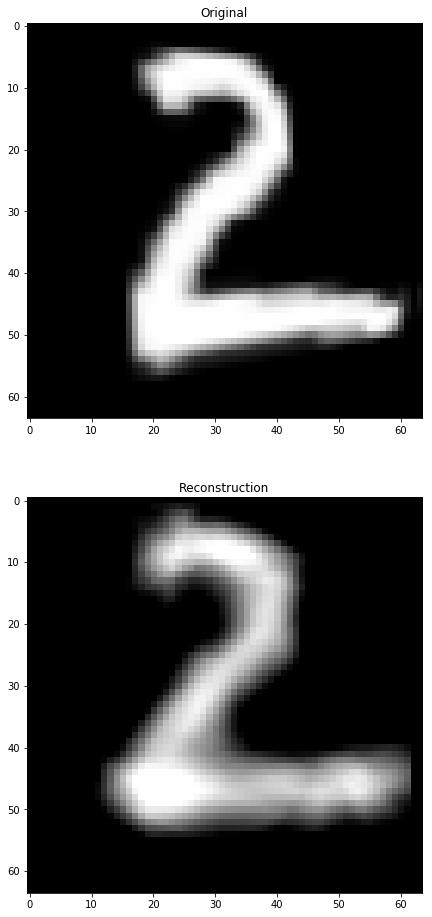

In [8]:
learn.plot_rec()

In [9]:
learn.plot_shades()

UnboundLocalError: local variable 'n_z' referenced before assignment

Computing the TSNE projection


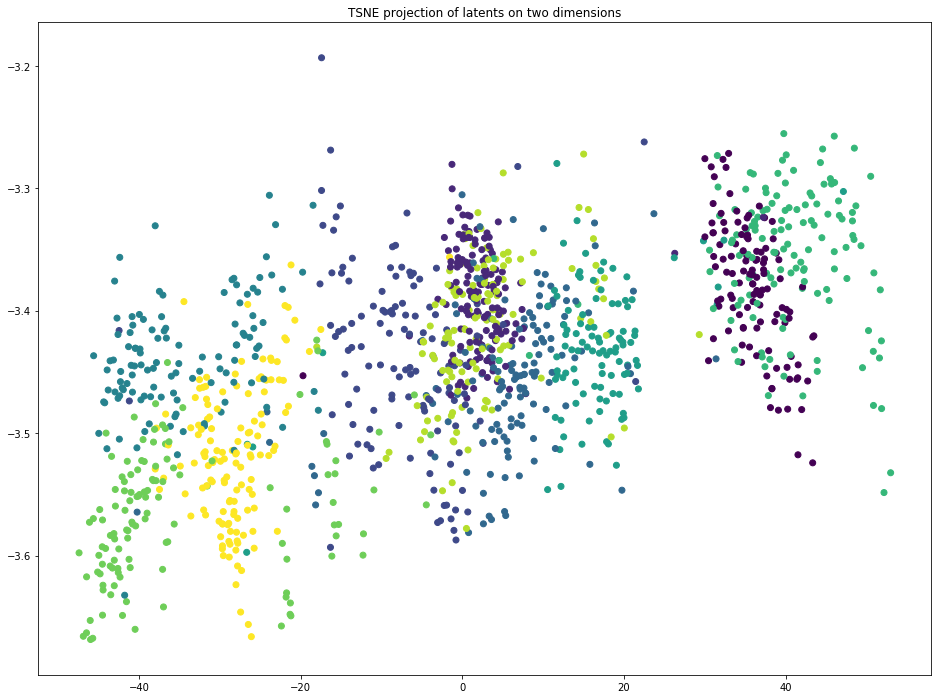

In [26]:
learn.plot_2d_latents(n_batch=20)

In [19]:
output = learn.get_error()

In [77]:
data = loss_func(x,x_rec).numpy()

In [90]:
alpha = np.percentile(data,95)

In [91]:
mask = (data > alpha)

In [108]:
values = learn.data.valid_ds.y.items[idx].reshape(-1)

In [109]:
pd.value_counts(values)

8    160
2    151
4     60
5     51
3     48
6     46
0     32
7     26
9     24
1      2
dtype: int64

In [92]:
idx = np.argwhere(np.asarray(mask))
outliers = x[idx]

In [81]:
def plot_img(x,x_rec,i):
    img = x[i].squeeze(0).permute(1,2,0).numpy()
    img = np.concatenate([img,img,img], axis = -1)
    
    img_rec = x_rec[i].squeeze(0).permute(1,2,0).numpy()
    img_rec = np.concatenate([img_rec,img_rec,img_rec], axis = -1)
    
    fig,ax = plt.subplots(2,figsize = (16,8))
    ax[0].imshow(img)
    ax[0].set_title("Original")
    
    ax[1].imshow(img_rec)
    ax[1].set_title("Reconstruction")

In [82]:
o, o_rec = x[idx], x_rec[idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


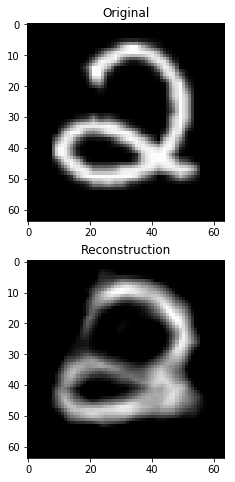

In [89]:
plot_img(o,o_rec,25)

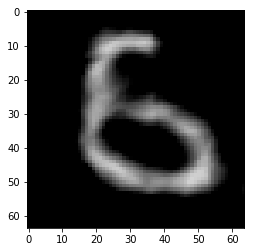

In [60]:
plot_img(outliers,0)

(array([9.780e+02, 1.386e+03, 2.149e+03, 2.220e+03, 1.858e+03, 1.309e+03, 8.390e+02, 5.040e+02, 3.010e+02, 1.870e+02,
        1.070e+02, 6.300e+01, 3.800e+01, 2.200e+01, 1.300e+01, 1.100e+01, 8.000e+00, 5.000e+00, 0.000e+00, 2.000e+00]),
 array([  3.559248,  10.69776 ,  17.836271,  24.974783,  32.113297,  39.25181 ,  46.39032 ,  53.52883 ,  60.667343,
         67.805855,  74.94437 ,  82.08288 ,  89.22139 ,  96.3599  , 103.49841 , 110.636925, 117.77544 , 124.91395 ,
        132.05246 , 139.19096 , 146.32948 ], dtype=float32),
 <a list of 20 Patch objects>)

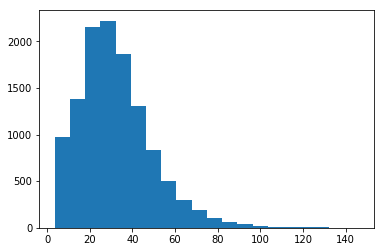

In [28]:
plt.hist(data,bins = 20)

In [24]:
loss_func = lambda x,x_rec : F.mse_loss(x, x_rec, reduction='none').view(x.shape[0], -1).sum(dim=-1)

In [16]:
t = x[0].permute(1,2,0).numpy()).float

In [20]:
t = np.concatenate([t,t,t],axis = -1)

In [29]:
data.valid_ds.x[2]

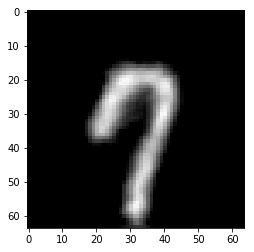

In [21]:
plt.imshow(t)

In [303]:
t = torch.load("encoder.pth")

In [94]:
t

Sequential(
  (0): Encoder(
    (enc_convs): Sequential(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
        (1): Sequential(
          (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (1): Sequential(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
        (1): Sequential(
          (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momen

In [95]:
path = untar_data(URLs.MNIST)
bs = 128
tfms = get_transforms(do_flip = False)

size = 64

data = (ImageList.from_folder(path/"training")
        .split_by_rand_pct(seed=42)
        .label_from_folder()
        .transform(tfms,size = size)
        .databunch(bs = bs))

def get_one_channel(batch):
    x,y = batch
    return x[:,0,:,:].unsqueeze(1),y
get_one_channel._order = 99

data.add_tfm(get_one_channel)

In [96]:
learn.data = data

In [241]:
x,y = learn.get_latents(ds_type=DatasetType.Train,n_batch=20)

In [242]:
x,y = x.numpy(),y.numpy()

In [243]:
from sklearn.ensemble import RandomForestClassifier

criterion = "entropy"

clf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42,
                            n_jobs=-1)

clf.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [244]:
y_pred = clf.predict(x)
(y_pred == y).mean()

0.9984375

In [245]:
x_val,y_val = learn.get_latents(ds_type=DatasetType.Valid)
x_val,y_val = x_val.numpy(),y_val.numpy()

In [246]:
y_pred = clf.predict(x_val)
(y_pred == y_val).mean()

0.8984166666666666